In [1]:
LEARNING_RATE  = 0.01
EPOCHS         = 5000
DROPOUT_RATE   = 0.1
TRAIN_CUTOFF   = 1200
SUBIMG_SPACING = 5
IMG_WIDTH      = 10
N_BCC_LIM      = 10
PCA_COMPONENTS = 20
NOISE_STD      = 3

## Imports and adapted functions

In [2]:
from ipynb.fs.full.CNN2D                import CNN2D, train_model, test_model, analyse_results
from ipynb.fs.full.Gniadecka_functions  import first_derivative_bl_removal
import numpy as np
from random import randint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [3]:
def make_peak(data, min_val, max_val, max_width):
    location  = randint(0,1023)
    amplitude = randint(min_val,max_val)
    width     = randint(0,max_width)
    
    for i in range (width):
        if location + i < 1024:
            data[location + i] = amplitude - 3*i
        if location - i >= 0:
            data[location - i] = amplitude - 3*i
    
    return data

In [4]:
def add_noise(healthy, bcc, mean,std):
    img_spectra = np.zeros((200,200,1024))

    for i in range(200):
        for j in range(200):
            if bcc_map[i,j] == 0:
                img_spectra[i,j] = healthy + np.random.normal(mean,std,1024)
            else:
                img_spectra[i,j] = bcc     + np.random.normal(mean,std,1024)
                
    return img_spectra

In [5]:
def add_baseline(data, max_amplitude):
    x    = np.linspace(0,1023,4)
    x_bl = np.linspace(0,1023,1024)
    
    coeff = [randint(0,max_amplitude),randint(0,max_amplitude),randint(0,max_amplitude),randint(0,max_amplitude)]
    f = interp1d(x,coeff,kind='cubic')
    baseline = f(x_bl)
    
    data += baseline
    return data

In [6]:
def my_pca(bcc_map, img_spectra, pca_components):
    ## Train PCA only on relevant BCC data
    pca_training_data = np.zeros((1000,1024))
    transformed       = np.zeros((200,200,pca_components))
    count = 0

    for i in range(200):
        for j in range(200):
            if count < 1000:
                if bcc_map[i,j] == 1:
                    pca_training_data[count,:] = img_spectra[i,j,:]
                    count += 1
                        
    ### Perform PCA dimensionality reduction ###
    norm_data = normalize(pca_training_data)
    pca = PCA(n_components=pca_components) 
    pca.fit(norm_data)

    for i in range(200):
        transformed[i,:,:] = pca.transform(img_spectra[i,:,:])
        
    return transformed

In [7]:
def subimages(bcc_map, spectra, img_width, subimg_spacing, pca_components, n_bcc_lim):
    sub_images = []
    target = []

    for i in range(0,200-img_width+1,subimg_spacing): # Can increase overlap - now 0 (40 spacing) 
        for j in range(0,200-img_width+1,subimg_spacing):
            sub_img = spectra[i:i+img_width,j:j+img_width,:]
            final_spectra = []
            
            # Change data structure from (40,40,PCA_COMPONENTS) to (PCA_COMPONENTS,40,40)
            for k in range(pca_components):
                wavenum = np.zeros((img_width,img_width))
                for m in range(img_width):
                    for n in range (img_width):
                        wavenum[m,n] = sub_img[m,n,k]
                final_spectra.append(wavenum)
            
            bcc = bcc_map[i:i+img_width,j:j+img_width]
            sub_images.append(final_spectra)
            if np.count_nonzero(bcc) > n_bcc_lim:
                target.append(1)
            else:
                target.append(0)
            
    return sub_images, target

## 0. Create image

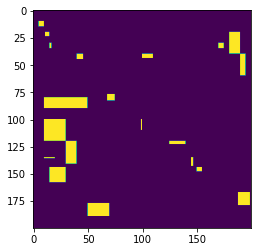

In [8]:
bcc_map = np.zeros((200,200))
bcc_map[10:15,5:10] = 1
bcc_map[20:24,11:15] = 1
bcc_map[30:35,15:17] = 1
bcc_map[40:45,40:46] = 1
bcc_map[77:83,68:75] = 1
bcc_map[100:110,99:100] = 1
bcc_map[120:123,125:140] = 1
bcc_map[135:143,145:147] = 1
bcc_map[144:148,150:155] = 1
bcc_map[167:179,188:199] = 1
bcc_map[20:40,180:190] = 1
bcc_map[30:35,170:175] = 1
bcc_map[40:60,190:195] = 1
bcc_map[40:44,100:110] = 1
bcc_map[80:90,10:50] = 1
bcc_map[100:120,10:30] = 1
bcc_map[120:141,30:40] = 1
bcc_map[135,10:20] = 1
bcc_map[144:158,15:30] = 1
bcc_map[177:189,50:70] = 1
plt.imshow(bcc_map)

## 1. Create "ideal" spectra for healthy vs. BCC

In [9]:
healthy = np.zeros((1024))
bcc     = np.zeros((1024))

# 5 big peaks, 10 small peaks
for i in range(5):
    healthy = make_peak(healthy, 30,60,20)
    bcc     = make_peak(bcc    , 30,60,20)
for i in range(10):
    healthy = make_peak(healthy, 1, 30,10)
    bcc     = make_peak(bcc    , 1, 30,10)
    
# Remove negative elements (make_peak can return negative values)
healthy = [0 if i < 0 else i for i in healthy]
bcc     = [0 if i < 0 else i for i in bcc]


## 2. Add 0-mean Gaussian noise 

In [10]:
mean = 0
img_spectra = add_noise(healthy,bcc,mean,NOISE_STD)

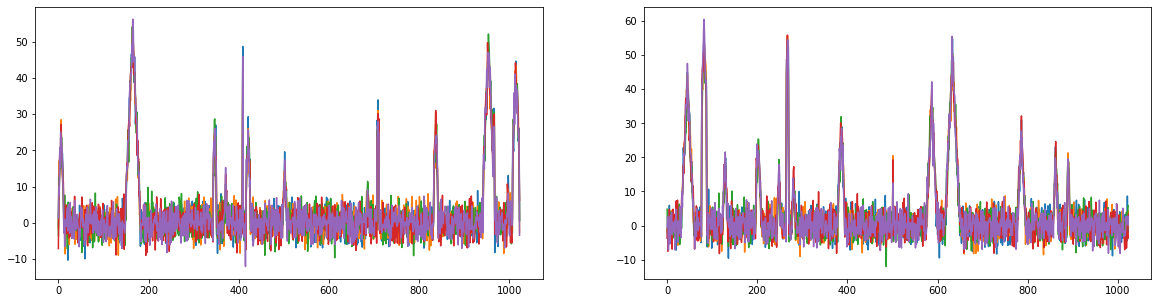

In [ ]:
_, axs = plt.subplots(1,2, figsize=(20,5))
axs[0].plot(np.transpose(img_spectra[0:5,0,:]))
axs[1].plot(np.transpose(img_spectra[30:35,15,:]))

## 3. Add and remove baseline

In [ ]:
for i in range(200):
    for j in range(200):
        img_spectra[i,j]     = add_baseline(img_spectra[i,j],50)
        x = np.linspace(0,1023,1024)
        [img_spectra[i,j],_] = first_derivative_bl_removal(x,img_spectra[i,j])

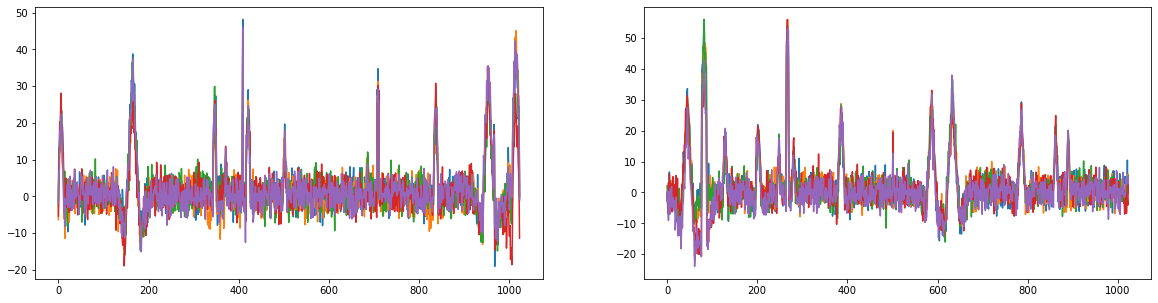

In [ ]:
_, axs = plt.subplots(1,2, figsize=(20,5))
axs[0].plot(np.transpose(img_spectra[0:5,0,:]))
axs[1].plot(np.transpose(img_spectra[30:35,15,:]))


## 4. Perform PCA

In [ ]:
pca_reduced = my_pca(bcc_map,img_spectra,PCA_COMPONENTS)

## 5. Subimages

In [ ]:
sub_images, target = subimages(bcc_map, pca_reduced, IMG_WIDTH, SUBIMG_SPACING, PCA_COMPONENTS, N_BCC_LIM)

## 6. CNN

In [ ]:
model = CNN2D(IMG_WIDTH,PCA_COMPONENTS,DROPOUT_RATE)
train_model(model, sub_images[:TRAIN_CUTOFF], target[:TRAIN_CUTOFF], LEARNING_RATE, EPOCHS, IMG_WIDTH, PCA_COMPONENTS)

 14%|█▍        | 708/5000 [00:20<02:05, 34.15it/s]

Training error = 0.0%
Test error = 0.0%


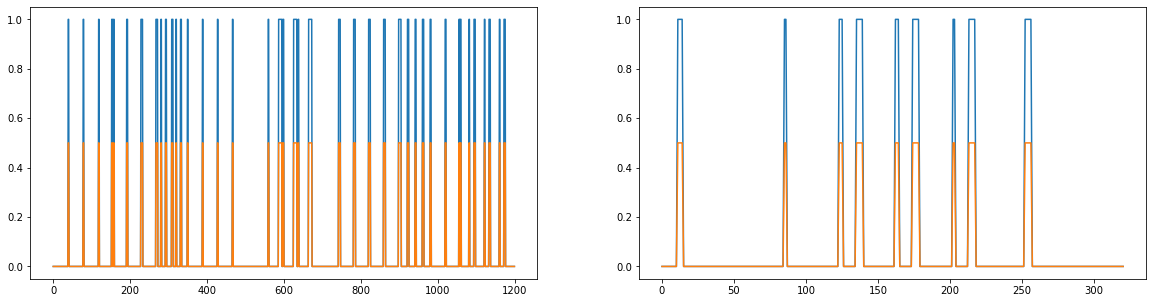

In [ ]:
approximation_train = test_model(model, sub_images[:TRAIN_CUTOFF], IMG_WIDTH, PCA_COMPONENTS)
approximation_test  = test_model(model, sub_images[TRAIN_CUTOFF:], IMG_WIDTH, PCA_COMPONENTS)

_ = analyse_results(approximation_train, approximation_test, target, TRAIN_CUTOFF, plot=1)